In [642]:
import os
import sys
import numpy as np
import pandas as pd
import nltk
nltk.download('wordnet')
nltk.download('brown')
nltk.download('maxent_ne_chunker')
from nltk.corpus import brown
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from nltk.tokenize import TreebankWordTokenizer
from nltk.tag import hmm
import spacy
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from spacy.tokens import Doc
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM, Bidirectional
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras import layers
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers.recurrent import LSTM, RNN
from IPython.display import display, Image
from keras import backend as K 
from IPython.display import display, Image

from functools import reduce
import tarfile
import numpy as np
import re

from keras.layers import Dense, Bidirectional
from keras.layers import Flatten, SpatialDropout1D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from IPython.display import display, Image

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mimi_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\mimi_\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\mimi_\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


In [ ]:
# Code to download train, test files and pre-trained word embedding into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1bqMaVrIHRiUprtBCDs6EHhAkD-KepAUc'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('WikiQA-train.tsv') 

id = '1cNW1n-Eg4uXizjgRvzQqHM7R24XkgzqF'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('WikiQA-test.tsv') 

id = '17IxNWawzBLrh4rmwwuemnVMQ9vYZQo35'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('glove.6B.100d.txt')

In [643]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR)

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding ="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [644]:
# train.tsv
df_train=pd.read_csv('WikiQA-train.tsv', sep='\t')
# test.tsv
df_test=pd.read_csv('WikiQA-test.tsv', sep='\t')

In [645]:
# data wrangling part
tknzr = TreebankWordTokenizer()

def data_wrangle(source_df):
    dataset = []
    sentence = []
    answer = []
    my_dict = {}
    keys = ['document','question', 'answer']
    my_dict.fromkeys(keys, [])
    unique_questions = source_df['QuestionID'].unique()
    for q in unique_questions:
        my_dict = {}
        sentence = []
        answer  = []
        df_source_q = source_df.loc[source_df['QuestionID'] == q]
        df_source_q.reset_index(inplace=True)
        question = tknzr.tokenize(df_source_q.Question[0])
        num_rows = df_source_q.shape[0]
        for i in range(num_rows):
            sentence.append(tknzr.tokenize(df_source_q.Sentence[i]))
        df = df_source_q.loc[df_source_q['Label'] == 1]
        df.reset_index(inplace=True)
        my_dict['document'] = sentence
        my_dict['question'] = question

        if df.empty == False:
            for j in range(df.shape[0]):
                answer = tknzr.tokenize(df.Sentence[j])
                my_dict['answer'] = answer
                dataset.append(my_dict.copy())
        else:
            my_dict['answer'] = []
            dataset.append(my_dict.copy())
    
    return dataset

train_dataset = data_wrangle(df_train)
test_dataset = data_wrangle(df_test)

In [197]:
# after data wrangling, each row looks like this
print(train_dataset[0])

{'document': [['A', 'partly', 'submerged', 'glacier', 'cave', 'on', 'Perito', 'Moreno', 'Glacier', '.'], ['The', 'ice', 'facade', 'is', 'approximately', '60', 'm', 'high'], ['Ice', 'formations', 'in', 'the', 'Titlis', 'glacier', 'cave'], ['A', 'glacier', 'cave', 'is', 'a', 'cave', 'formed', 'within', 'the', 'ice', 'of', 'a', 'glacier', '.'], ['Glacier', 'caves', 'are', 'often', 'called', 'ice', 'caves', ',', 'but', 'this', 'term', 'is', 'properly', 'used', 'to', 'describe', 'bedrock', 'caves', 'that', 'contain', 'year-round', 'ice', '.']], 'question': ['how', 'are', 'glacier', 'caves', 'formed', '?'], 'answer': ['A', 'glacier', 'cave', 'is', 'a', 'cave', 'formed', 'within', 'the', 'ice', 'of', 'a', 'glacier', '.']}


In [646]:
# remove training instances with no answer
new_train = []
for datarow in train_dataset:
    if datarow['answer']:
        new_train.append(datarow)
        
train_dataset = new_train

In [647]:
# while word embedding, whenever we get out of vocabulary error, we make the word embedding zeros(shape = 100)
def catch_NOV_error(func, handle=lambda e : e, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return np.zeros(shape=(100,))

In [648]:
# make separate lists for question and answers from train and test dataset
q_list_train = []
for train_datarow in train_dataset:
    for k, v in train_datarow.items():
        if k =='question':
            q_list_train.append(v)
            
q_list_test = []
for test_datarow in test_dataset:
    for k, v in test_datarow.items():
        if k =='question':
            q_list_test.append(v)
            
a_list_train = []
for train_datarow in train_dataset:
    for k, v in train_datarow.items():
        if k =='answer':
            a_list_train.append(v)
            
a_list_test = []
for test_datarow in test_dataset:
    for k, v in test_datarow.items():
        if k =='answer':
            a_list_test.append(v)

In [649]:
## doc_corpus is the compilation of documents from train dataset--> tokenized sentences. 3D list. 
# Each sentence is a list. Each document is a list of list. The whole document corpus id list of list of list
doc_corpus = []
for i in range(len(train_dataset)):
    doc_corpus.append(train_dataset[i]['document'])


## doc_corpus_test is the compilation of documents from test dataset--> tokenized sentences. 3D list
# Each sentence is a list. Each document is a list of list. The whole document corpus id list of list of list
doc_corpus_test = []
for i in range(len(test_dataset)):
    doc_corpus_test.append(test_dataset[i]['document'])

In [650]:
## q_corpus is the compilation of questions from train dataset--> tokenized questions. 2D list
# each question is a list
# question corpus is list of list
q_corpus = []
for i in range(len(train_dataset)):
    q_corpus.append(train_dataset[i]['question'])

## q_corpus_test is the compilation of questions from test dataset--> tokenized questions. 2D list
# each question is a list
# question corpus is list of list
q_corpus_test = []
for i in range(len(test_dataset)):
    q_corpus_test.append(test_dataset[i]['question'])

In [651]:
# main feature extraction logic is given below

In [652]:
## 5 features together on train dataset
# pos extraction--> document_pos 
# tf-idf extraction --> doc_corpus_tf
# word match extraction--> doc_corpus_match
# named entity tag extraction--> doc_corpus_ner
# dependency extraction ---> doc_corpus_dep
# all the above lists mentioned aboove are 3D list. Because each sentence is a list.
 
#custom function to get tf-idf on tokenized sentence. 
def dummy_fun(doc):
    return doc 

# this custom function is used to make sure nlp(sentence) uses same tokenization method that we did in data wrangling part
def custom_tokenizer(text):
    tokens = []
    tknzr = TreebankWordTokenizer()
    tokens = tknzr.tokenize(text)
    return Doc(nlp.vocab, tokens)

lemmatizer = WordNetLemmatizer()
doc_corpus_match = []
nltk.download('averaged_perceptron_tagger')
document_pos = []
doc_corpus_tf = []
# loading pre-trained model of NER
nlp = en_core_web_sm.load()
doc_corpus_ner = []
doc_corpus_dep = []

for i in range(len(doc_corpus)):
    doc_match = []
    doc_pos = []
    tfidf = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None) 
    response = tfidf.fit_transform(doc_corpus[i])
    j = 0
    doc_tf = []
    sent_ner = []
    sents = []
    sent_dep = []
    k = 0
    for sent in doc_corpus[i]:
        sent_match = []
        sent_tf = []
        sents.append(' '.join(sent))
        nlp.tokenizer = custom_tokenizer
        sent_ner.append([x.ent_type_ for x in nlp(sents[k])])
        sent_dep.append([x.dep_ for x in nlp(sents[k])])
        k+=1
        doc_pos.append([x[1] for x in nltk.pos_tag(sent)])
        for word in sent:
            word_idx = tfidf.vocabulary_[word]
            tf_value = response[j, word_idx]
            sent_tf.append(tf_value)
            word = lemmatizer.lemmatize(word)
            if word.lower() in q_corpus[i]:
                word_match = 1
            else:
                word_match = 0
            sent_match.append(word_match)
        doc_match.append(sent_match)
        j+=1
        doc_tf.append(sent_tf)
    doc_corpus_ner.append(sent_ner)
    doc_corpus_dep.append(sent_dep)
    doc_corpus_tf.append(doc_tf)
    document_pos.append(doc_pos)
    doc_corpus_match.append(doc_match)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mimi_\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [504]:
print(doc_corpus_ner[0][0])
print(doc_corpus_dep[0][0])
print(doc_corpus_tf[0][0])
print(document_pos[0][0])
print(doc_corpus_match[0][0])
print(embeddings_index['glacier'])

['', '', '', '', '', '', 'ORG', 'ORG', 'ORG', '']
['det', 'advmod', 'amod', 'amod', 'ROOT', 'prep', 'compound', 'compound', 'pobj', 'punct']
[0.2917469711981098, 0.3616128508896497, 0.3616128508896497, 0.24217634067675992, 0.24217634067675992, 0.3616128508896497, 0.3616128508896497, 0.3616128508896497, 0.2917469711981098, 0.24217634067675992]
['DT', 'RB', 'VBN', 'NN', 'NN', 'IN', 'NNP', 'NNP', 'NNP', '.']
[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
[-0.721     -0.3444     0.30293    1.0707    -0.35202   -0.62779
  0.78712    0.35055   -0.48645   -0.98224    0.29991    1.2228
  0.046493  -0.0020069  0.64803    0.32369    0.68511   -0.50733
 -0.31599   -0.73471   -0.028902   1.1335    -0.33361    0.01657
  0.20583    0.88333   -0.48279   -0.28511    0.29727   -1.1643
 -0.13279    0.12642    0.22006   -0.087663   0.31755   -0.064759
  0.88653    0.75787    0.022985  -0.3818    -0.90049    0.11869
 -0.49125    0.35674    0.69337    0.7812     0.97443    0.29863
  0.87699    0.9023     0.68418    0.0442

In [653]:
## 5 features together test dataset
# pos extraction--> document_pos_test
# tf-idf extraction --> doc_corpus_tf_test
# word match extraction--> doc_corpus_match_test
# named entity tag extraction--> doc_corpus_ner_test
# dependency extraction ---> doc_corpus_dep_test
# all the above lists mentioned aboove are 3D list. Because each sentence is a list.


def dummy_fun(doc):
    return doc 

def custom_tokenizer(text):
    tokens = []
    tknzr = TreebankWordTokenizer()
    tokens = tknzr.tokenize(text)
    return Doc(nlp.vocab, tokens)

lemmatizer = WordNetLemmatizer()
doc_corpus_match_test = []
# nltk.download('averaged_perceptron_tagger')
document_pos_test = []
doc_corpus_tf_test = []
# loading pre-trained model of NER
nlp = en_core_web_sm.load()
doc_corpus_ner_test = []
doc_corpus_dep_test = []

for i in range(len(doc_corpus_test)):
    doc_match = []
    doc_pos = []
    tfidf = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None) 
    response = tfidf.fit_transform(doc_corpus_test[i])
    j = 0
    doc_tf = []
    sent_ner = []
    sents = []
    sent_dep = []
    k = 0
    for sent in doc_corpus_test[i]:
        sent_match = []
        sent_tf = []
        sents.append(' '.join(sent))
        nlp.tokenizer = custom_tokenizer
        sent_ner.append([x.ent_type_ for x in nlp(sents[k])])
        sent_dep.append([x.dep_ for x in nlp(sents[k])])
        k+=1
        doc_pos.append([x[1] for x in nltk.pos_tag(sent)])
        for word in sent:
            word_idx = tfidf.vocabulary_[word]
            tf_value = response[j, word_idx]
            sent_tf.append(tf_value)
            word = lemmatizer.lemmatize(word)
            if word.lower() in q_corpus[i]:
                word_match = 1
            else:
                word_match = 0
            sent_match.append(word_match)
        doc_match.append(sent_match)
        j+=1
        doc_tf.append(sent_tf)
    doc_corpus_ner_test.append(sent_ner)
    doc_corpus_dep_test.append(sent_dep)
    doc_corpus_tf_test.append(doc_tf)
    document_pos_test.append(doc_pos)
    doc_corpus_match_test.append(doc_match)

In [375]:
## we are going to flatten the feature lists so that each document becomes one list.
## feature lists are - doc_ner_list, doc_dep_list, doc_tf_list, doc_pos_list, doc_match_list, doc_word_list
## these are feature lists on train set

doc_list = []
for doc_instance in doc_corpus:
    doc_flat_list= []
    doc_flat_list = [y for x in doc_instance for y in x]
    doc_list.append(doc_flat_list)
    
doc_ner_list = []
for doc_instance in doc_corpus_ner:
    doc_flat_list= []
    doc_flat_list = [y for x in doc_instance for y in x]
    doc_ner_list.append(doc_flat_list)
    
doc_dep_list = []
for doc_instance in doc_corpus_dep:
    doc_flat_list= []
    doc_flat_list = [y for x in doc_instance for y in x]
    doc_dep_list.append(doc_flat_list)
    
doc_tf_list = []
for doc_instance in doc_corpus_tf:
    doc_flat_list= []
    doc_flat_list = [round(y, 3) for x in doc_instance for y in x]
    doc_tf_list.append(doc_flat_list)
    
doc_pos_list = []
for doc_instance in document_pos:
    doc_flat_list= []
    doc_flat_list = [y for x in doc_instance for y in x]
    doc_pos_list.append(doc_flat_list)
    
doc_match_list = []
for doc_instance in doc_corpus_match:
    doc_flat_list= []
    doc_flat_list = [y for x in doc_instance for y in x]
    doc_match_list.append(doc_flat_list)


In [512]:
print(doc_corpus_match[0])

[[0, 0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [654]:
## we are going to flatten the feature lists so that each document becomes one list.
## feature lists are - doc_ner_list_test, doc_dep_list_test, doc_tf_list_test, doc_pos_list_test, doc_match_list_test, doc_word_list_test
## these are feature lists on test set

doc_list_test = []
for doc_instance in doc_corpus_test:
    doc_flat_list= []
    doc_flat_list = [y for x in doc_instance for y in x]
    doc_list_test.append(doc_flat_list)
    
doc_ner_list_test = []
for doc_instance in doc_corpus_ner_test:
    doc_flat_list= []
    doc_flat_list = [y for x in doc_instance for y in x]
    doc_ner_list_test.append(doc_flat_list)
    
doc_dep_list_test = []
for doc_instance in doc_corpus_dep_test:
    doc_flat_list= []
    doc_flat_list = [y for x in doc_instance for y in x]
    doc_dep_list_test.append(doc_flat_list)
    
doc_tf_list_test = []
for doc_instance in doc_corpus_tf_test:
    doc_flat_list= []
    doc_flat_list = [round(y, 3) for x in doc_instance for y in x]
    doc_tf_list_test.append(doc_flat_list)
    
doc_pos_list_test = []
for doc_instance in document_pos_test:
    doc_flat_list= []
    doc_flat_list = [y for x in doc_instance for y in x]
    doc_pos_list_test.append(doc_flat_list)
    
doc_match_list_test = []
for doc_instance in doc_corpus_match_test:
    doc_flat_list= []
    doc_flat_list = [y for x in doc_instance for y in x]
    doc_match_list_test.append(doc_flat_list)


In [655]:
# create vocabulary with unique values of pos tagging, dependency parsing, 
# tf-idf, NER and word-embedding from train dataset
pos_vocab = []
for sent_pos in doc_pos_list:
    for pos in sent_pos:
        if pos not in pos_vocab:
            pos_vocab.append(pos)
            
dep_vocab = []
for sent_dep in doc_dep_list:
    for dep in sent_dep:
        if dep not in dep_vocab:
            dep_vocab.append(dep)

ner_vocab = []
for sent_ner in doc_ner_list:
    for ner in sent_ner:
        if ner not in ner_vocab:
            ner_vocab.append(ner)   
            
tf_vocab = []
for sent_tf in doc_tf_list+doc_tf_list_test:
    for tf in sent_tf:
        if tf not in tf_vocab:
            tf_vocab.append(tf) 
            
doc_vocab = []
for sent in doc_list+doc_list_test+q_list_train+q_list_test:
    for word in sent:
        if word.lower() not in doc_vocab:
            doc_vocab.append(word.lower()) 
                        


In [656]:
## create dictionaries to map each unique value of vocab to an index
## create new lists for features where each value represents the index of the feature
dep_dict = {}
for idx, item in enumerate(dep_vocab):
    dep_dict[item] = idx+1

dep_idx_train = []
for sent_dep in doc_dep_list:
    dep_dict_sent = []
    for dep in sent_dep:
        dep_dict_sent.append(dep_dict[dep])   
    dep_idx_train.append(dep_dict_sent)
    
pos_dict = {}
for idx, item in enumerate(pos_vocab):
    pos_dict[item] = idx+1

pos_idx_train = []
for sent_pos in doc_pos_list:
    pos_dict_sent = []
    for pos in sent_pos:
        pos_dict_sent.append(pos_dict[pos])   
    pos_idx_train.append(pos_dict_sent)
    
ner_dict = {}
for idx, item in enumerate(ner_vocab):
    ner_dict[item] = idx+1

ner_idx_train = []
for sent_ner in doc_ner_list:
    ner_dict_sent = []
    for ner in sent_ner:
        ner_dict_sent.append(ner_dict[ner])   
    ner_idx_train.append(ner_dict_sent)

tf_dict = {}
for idx, item in enumerate(tf_vocab):
    tf_dict[item] = idx+1
    
tf_idx_train = []
for sent_tf in doc_tf_list:
    tf_dict_sent = []
    for tf in sent_tf:
        tf_dict_sent.append(tf_dict[tf])   
    tf_idx_train.append(tf_dict_sent)
    
doc_dict = {}
for idx, item in enumerate(doc_vocab):
    doc_dict[item] = idx+1
    
    
doc_idx_train = []
for sent in doc_list:
    doc_dict_sent = []
    for word in sent:
        doc_dict_sent.append(doc_dict[word.lower()])   
    doc_idx_train.append(doc_dict_sent)
    
    
q_dict = {}
for idx, item in enumerate(doc_vocab):
    q_dict[item] = idx+1
    
q_idx_train = []
for sent in q_list_train:
    q_dict_sent = []
    for word in sent:
        q_dict_sent.append(doc_dict[word.lower()])   
    q_idx_train.append(q_dict_sent)
    
    
a_idx_train = []
for sent in a_list_train:
    a_dict_sent = []
    for word in sent:
        a_dict_sent.append(doc_dict[word.lower()])   
    a_idx_train.append(a_dict_sent)



In [ ]:
# final 6 train document features are these
# dep_idx_train  -> for dependecy parsing. Each document is a list.
# pos_idx_train --> for pos tagging. Each document is a list.
# ner_idx_train -> for NER. Each document is a list.
# doc_tf_list -> for tf-idf. Each document is a list.
# doc_word_list -> for word embedding. Each document is a list.
# doc_match_list -> for word match feature. Each document is a list.

# question feature of train dataset
# word_question_train --> for word2vec. Each question is a list.

In [657]:
## Now, let's create the indexed list for test dataset from training vocabulary.
## All the values of dependency parsing, pos tagging and NER of test dataset are present in feature vocabulary.
## dep_idx_test, pos_idx_test, ner_idx_test --> 2D list. Each document is a list.
## each item in these lists are an index of feature value. 

dep_idx_test = []
for sent_dep in doc_dep_list_test:
    dep_dict_sent = []
    for dep in sent_dep:
        dep_dict_sent.append(dep_dict[dep])   
    dep_idx_test.append(dep_dict_sent)
    
pos_idx_test = []
for sent_pos in doc_pos_list_test:
    pos_dict_sent = []
    for pos in sent_pos:
        pos_dict_sent.append(pos_dict[pos])   
    pos_idx_test.append(pos_dict_sent)
    
ner_idx_test = []
for sent_ner in doc_ner_list_test:
    ner_dict_sent = []
    for ner in sent_ner:
        ner_dict_sent.append(ner_dict[ner])   
    ner_idx_test.append(ner_dict_sent)
    
tf_idx_test = []
for sent_tf in doc_tf_list_test:
    tf_dict_sent = []
    for tf in sent_tf:
        tf_dict_sent.append(tf_dict[tf]) 
    tf_idx_test.append(tf_dict_sent)
    
doc_idx_test = []
for sent in doc_list_test:
    doc_dict_sent = []
    for word in sent:
        doc_dict_sent.append(doc_dict[word.lower()]) 
    doc_idx_test.append(doc_dict_sent)
    
q_idx_test = []
for sent in q_list_test:
    q_dict_sent = []
    for word in sent:
        q_dict_sent.append(doc_dict[word.lower()]) 
    q_idx_test.append(q_dict_sent)
    
    
a_idx_test = []
for sent in a_list_test:
    a_dict_sent = []
    for word in sent:
        if word.lower() in doc_dict.keys():
            a_dict_sent.append(doc_dict[word.lower()]) 
        else:
            a_dict_sent.append(len(doc_vocab)+1)
    a_idx_test.append(a_dict_sent)

In [658]:
# final 6 test document features are these
# dep_idx_test  -> for dependecy parsing. Each document is a list.
# pos_idx_test --> for pos tagging. Each document is a list.
# ner_idx_test -> for NER. Each document is a list.
# doc_tf_list_test -> for tf-idf. Each document is a list.
# doc_word_list_test -> for word embedding. Each document is a list.
# doc_match_list_test -> for word match feature. Each document is a list.

# question feature of test dataset
# word_question_test --> for word2vec. Each question is a list.

In [659]:
# find maximum length of question
maxlen_q = max(len(q) for q in (q_corpus+q_corpus_test))
print(maxlen_q)

# find maximum length of document
maxlen_doc = max(len(doc) for doc in (doc_list+doc_list_test))
print(maxlen_doc)

22
1728


In [660]:
## pad all the document features to same length(1728)
## pad the list with 0 vector
from keras.preprocessing.sequence import pad_sequences
padded_dep_train = pad_sequences(dep_idx_train, maxlen=maxlen_doc, padding='post', value = 0)
padded_pos_train = pad_sequences(pos_idx_train, maxlen=maxlen_doc, padding='post', value = 0)
padded_ner_train = pad_sequences(ner_idx_train, maxlen=maxlen_doc, padding='post', value = 0)
padded_match_train = pad_sequences(doc_match_list, maxlen=maxlen_doc, padding='post', value = 0)
padded_tf_train =  pad_sequences(tf_idx_train, maxlen=maxlen_doc, padding='post', value = 0)
padded_word_train =  pad_sequences(doc_idx_train, maxlen=maxlen_doc, padding='post', value = 0)
# 
padded_dep_test = pad_sequences(dep_idx_test, maxlen=maxlen_doc, padding='post', value = 0)
padded_pos_test = pad_sequences(pos_idx_test, maxlen=maxlen_doc, padding='post', value = 0)
padded_ner_test = pad_sequences(ner_idx_test, maxlen=maxlen_doc, padding='post', value = 0)
padded_match_test = pad_sequences(doc_match_list_test, maxlen=maxlen_doc, padding='post', value = 0)
padded_tf_test =  pad_sequences(tf_idx_test, maxlen=maxlen_doc, padding='post', value = 0)
padded_word_test =  pad_sequences(doc_idx_test, maxlen=maxlen_doc, padding='post', value = 0)

## pad all the question features to same length(22)
padded_wordQ_train =  pad_sequences(q_idx_train, maxlen=maxlen_q, padding='post', value = 0)
padded_wordQ_test =  pad_sequences(q_idx_test, maxlen=maxlen_q, padding='post', value = 0)

## pad all the answer features to same length(1728)
padded_wordA_train =  pad_sequences(a_idx_train, maxlen=maxlen_doc, padding='post', value = 0)
padded_wordA_test =  pad_sequences(a_idx_test, maxlen=maxlen_doc, padding='post', value = 0)

In [661]:
# these are the indexes of first document in traing dataset
print(dep_idx_train[0])
print(pos_idx_train[0])
print(ner_idx_train[0])
print(doc_match_list[0])
print(tf_idx_train[0])
print(doc_idx_train[0])

[1, 2, 3, 3, 4, 5, 6, 6, 7, 8, 1, 6, 9, 4, 2, 10, 11, 12, 3, 4, 5, 1, 13, 3, 7, 1, 3, 9, 4, 1, 14, 15, 5, 1, 7, 5, 1, 7, 8, 3, 16, 17, 2, 4, 6, 18, 8, 19, 1, 16, 17, 2, 20, 21, 22, 6, 23, 9, 24, 3, 23, 8]
[1, 2, 3, 4, 4, 5, 6, 6, 6, 7, 1, 4, 4, 8, 2, 9, 10, 11, 6, 10, 5, 1, 6, 4, 4, 1, 4, 4, 8, 1, 4, 3, 5, 1, 4, 5, 1, 4, 7, 6, 10, 12, 2, 3, 4, 10, 13, 14, 1, 4, 8, 2, 3, 15, 16, 4, 10, 17, 12, 11, 4, 7]
[1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 2, 2, 3, 3, 2, 2, 2, 1, 3, 4, 5, 4, 5, 4, 4, 4, 4, 6, 6, 6, 7, 6, 8, 8, 9, 10, 10, 11, 12, 10, 13, 13, 9, 11, 13, 12, 10, 11, 14, 15, 16, 16, 16, 17, 15, 16, 16, 16, 16, 18, 16, 16, 16, 16, 16, 15, 16, 16, 16, 17, 18

In [662]:
pretrained_list = [np.ones(shape=100, dtype='float32')]        
for word in doc_dict.keys():
    pretrained_list.append(np.array(catch_NOV_error(lambda : embeddings_index[word.lower()])))

dep_vocab_list = [0]
for k,v in dep_dict.items():
    dep_vocab_list.append(v)
    
pos_vocab_list = [0]
for k,v in pos_dict.items():
    pos_vocab_list.append(v)
    
ner_vocab_list = [0]
for k,v in ner_dict.items():
    ner_vocab_list.append(v)
    
match_vocab_list = [0,1]
    
tf_vocab_list = [0]
for k,v in tf_dict.items():
    tf_vocab_list.append(v)
    

In [663]:
ner_vocab_list = np.reshape(np.array(ner_vocab_list), (-1,1))
pos_vocab_list = np.reshape(np.array(pos_vocab_list), (-1,1))
tf_vocab_list = np.reshape(np.array(tf_vocab_list), (-1,1))
dep_vocab_list = np.reshape(np.array(dep_vocab_list), (-1,1))
match_vocab_list = np.reshape(np.array(match_vocab_list), (-1,1))

In [664]:
# extract word embedding indexes of first and last tokens of training dataset
train_answer_first_token = []
for row in padded_wordA_train:
    train_answer_first_token.append(row[0])
    
train_answer_last_token = []
for row in a_idx_train:
    if row:
        if row[-1] == doc_dict['.']:
             train_answer_last_token.append(row[-2])   
        else:
            train_answer_last_token.append(row[-1])
    else:
        train_answer_last_token.append(0)

In [665]:
# extract word embedding indexes of first and last tokens of test dataset
test_answer_first_token = []
for row in padded_wordA_test:
    test_answer_first_token.append(row[0])
    
test_answer_last_token = []
for row in a_idx_test:
    if row:
        if row[-1] == doc_dict['.']:
             test_answer_last_token.append(row[-2])   
        else:
            test_answer_last_token.append(row[-1])
    else:
        test_answer_last_token.append(0)

In [ ]:
# finally, after feature extraction each token is representaed by an index.
# e.g. token 'ice' of first document in training document is represented as [23,4,1,0,17,11]. 
# Here, 23 is the index of ‘ice’ in dependency parsing vocabulary, 4 is the index of pos tagging vocabulary etc.

In [666]:
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train feature shape:', padded_tf_train.shape)
print('inputs_test feature shape:', padded_tf_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train feature shape:', padded_wordQ_train.shape)
print('queries_test feature shape:', padded_wordQ_test.shape)

inputs: integer tensor of shape (samples, max_length)
inputs_train feature shape: (1039, 1728)
inputs_test feature shape: (680, 1728)
-
queries: integer tensor of shape (samples, max_length)
queries_train feature shape: (1039, 22)
queries_test feature shape: (680, 22)


In [667]:
# add 1 to vocabulary size for adding pad index
pos_vocab_size = len(pos_vocab) + 1
ner_vocab_size = len(ner_vocab) + 1
dep_vocab_size = len(dep_vocab) + 1
tf_vocab_size = len(tf_vocab) + 1
match_vocab_size = 2
doc_vocab_size = len(doc_vocab) + 1



In [668]:
# Model 1 -- considers all 5 featues
K.clear_session()

In [669]:
# input layer
in_pos =   Input((maxlen_doc,), name = 'pos')
in_dep =   Input((maxlen_doc,), name = 'dep')
in_tf =    Input((maxlen_doc,), name = 'tf')
in_match = Input((maxlen_doc,), name = 'match')
in_ner =   Input((maxlen_doc,), name = 'ner')
in_word =  Input((maxlen_doc,), name = 'word')


question = Input(shape=(maxlen_q,), name = 'question')

In [670]:
input_encoder_m1 = Sequential()
input_encoder_m1.add(Embedding(input_dim=doc_vocab_size, output_dim=100, weights = [np.array(pretrained_list)], 
                              input_length=maxlen_doc))
input_encoder_m1.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, doc_vocab_size, 100)))
input_encoder_m1.add(Dropout(0.3))
input_encoder_m1.add(Dense(1))

In [671]:
input_encoder_m2 = Sequential()
input_encoder_m2.add(Embedding(input_dim=dep_vocab_size, output_dim=1, weights = [dep_vocab_list],
                               input_length=maxlen_doc))
input_encoder_m2.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, dep_vocab_size, 1)))
input_encoder_m2.add(Dropout(0.3))
input_encoder_m2.add(Dense(1))

In [672]:
input_encoder_m3 = Sequential()
input_encoder_m3.add(Embedding(input_dim=pos_vocab_size, output_dim=1, weights = [pos_vocab_list],
                              input_length=maxlen_doc))
input_encoder_m3.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, pos_vocab_size, 1)))
input_encoder_m3.add(Dropout(0.3))
input_encoder_m3.add(Dense(1))

In [673]:
input_encoder_m4 = Sequential()
input_encoder_m4.add(Embedding(input_dim=ner_vocab_size, output_dim=1, weights = [ner_vocab_list],
                              input_length=maxlen_doc))
input_encoder_m4.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, ner_vocab_size, 1)))
input_encoder_m4.add(Dropout(0.3))
input_encoder_m4.add(Dense(1))

In [674]:
input_encoder_m5 = Sequential()
input_encoder_m5.add(Embedding(input_dim=match_vocab_size, output_dim=1, weights = [match_vocab_list],
                              input_length=maxlen_doc))
input_encoder_m5.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, match_vocab_size, 1)))
input_encoder_m5.add(Dropout(0.3))
input_encoder_m5.add(Dense(1))

In [675]:
input_encoder_m6 = Sequential()
input_encoder_m6.add(Embedding(input_dim=tf_vocab_size, output_dim=1, weights = [tf_vocab_list],
                              input_length=maxlen_doc))
input_encoder_m6.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, tf_vocab_size, 1)))
input_encoder_m6.add(Dropout(0.3))
input_encoder_m6.add(Dense(1))

In [676]:
# QUESTION ENCODER

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=doc_vocab_size,
                               output_dim=100 , weights = [np.array(pretrained_list)], 
                               input_length=maxlen_q))
question_encoder.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, doc_vocab_size, 100)))
question_encoder.add(Dropout(0.3))
question_encoder.add(Dense(6))
# output: (samples, query_maxlen, 6)

In [677]:
# ATTENTION

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m1 = input_encoder_m1(in_word)
input_encoded_m2 = input_encoder_m2(in_dep)
input_encoded_m3 = input_encoder_m3(in_pos)
input_encoded_m4 = input_encoder_m4(in_ner)
input_encoded_m5 = input_encoder_m5(in_match)
input_encoded_m6 = input_encoder_m6(in_tf)
input_encoded_m = concatenate([input_encoded_m1,input_encoded_m2,input_encoded_m3,
                              input_encoded_m4,input_encoded_m5,input_encoded_m6])


question_encoded = question_encoder(question)

# # compute a 'match' between the first input vector sequence
# # and the question vector sequence
# # shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)
response = Permute((2, 1))(match)  # (samples, query_maxlen, story_maxlen)

In [678]:
# print('input_encoded_c shape', input_encoded_c.shape)
print('input_encoded_m shape', input_encoded_m.shape)
print('question_encoded shape', question_encoded.shape)
print('match shape', match.shape)
print('response shape', response.shape)

input_encoded_m shape (?, 1728, 6)
question_encoded shape (?, 22, 6)
match shape (?, 1728, 22)
response shape (?, 22, 1728)


In [679]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded], axis = 2)

answer = LSTM(32)(answer)  # (samples, 32)
# one regularization layer
answer = Dropout(0.3)(answer)
answer = Dense(doc_vocab_size)(answer)  # (samples, vocab_size)

# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)
print('answer shape', answer.shape)
# build the final model

model_first = Model([in_word,in_dep,in_pos,in_ner,in_match,in_tf, question], answer)

model_first.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_last = Model([in_word,in_dep,in_pos,in_ner,in_match,in_tf, question], answer)

model_last.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

answer shape (?, 29227)


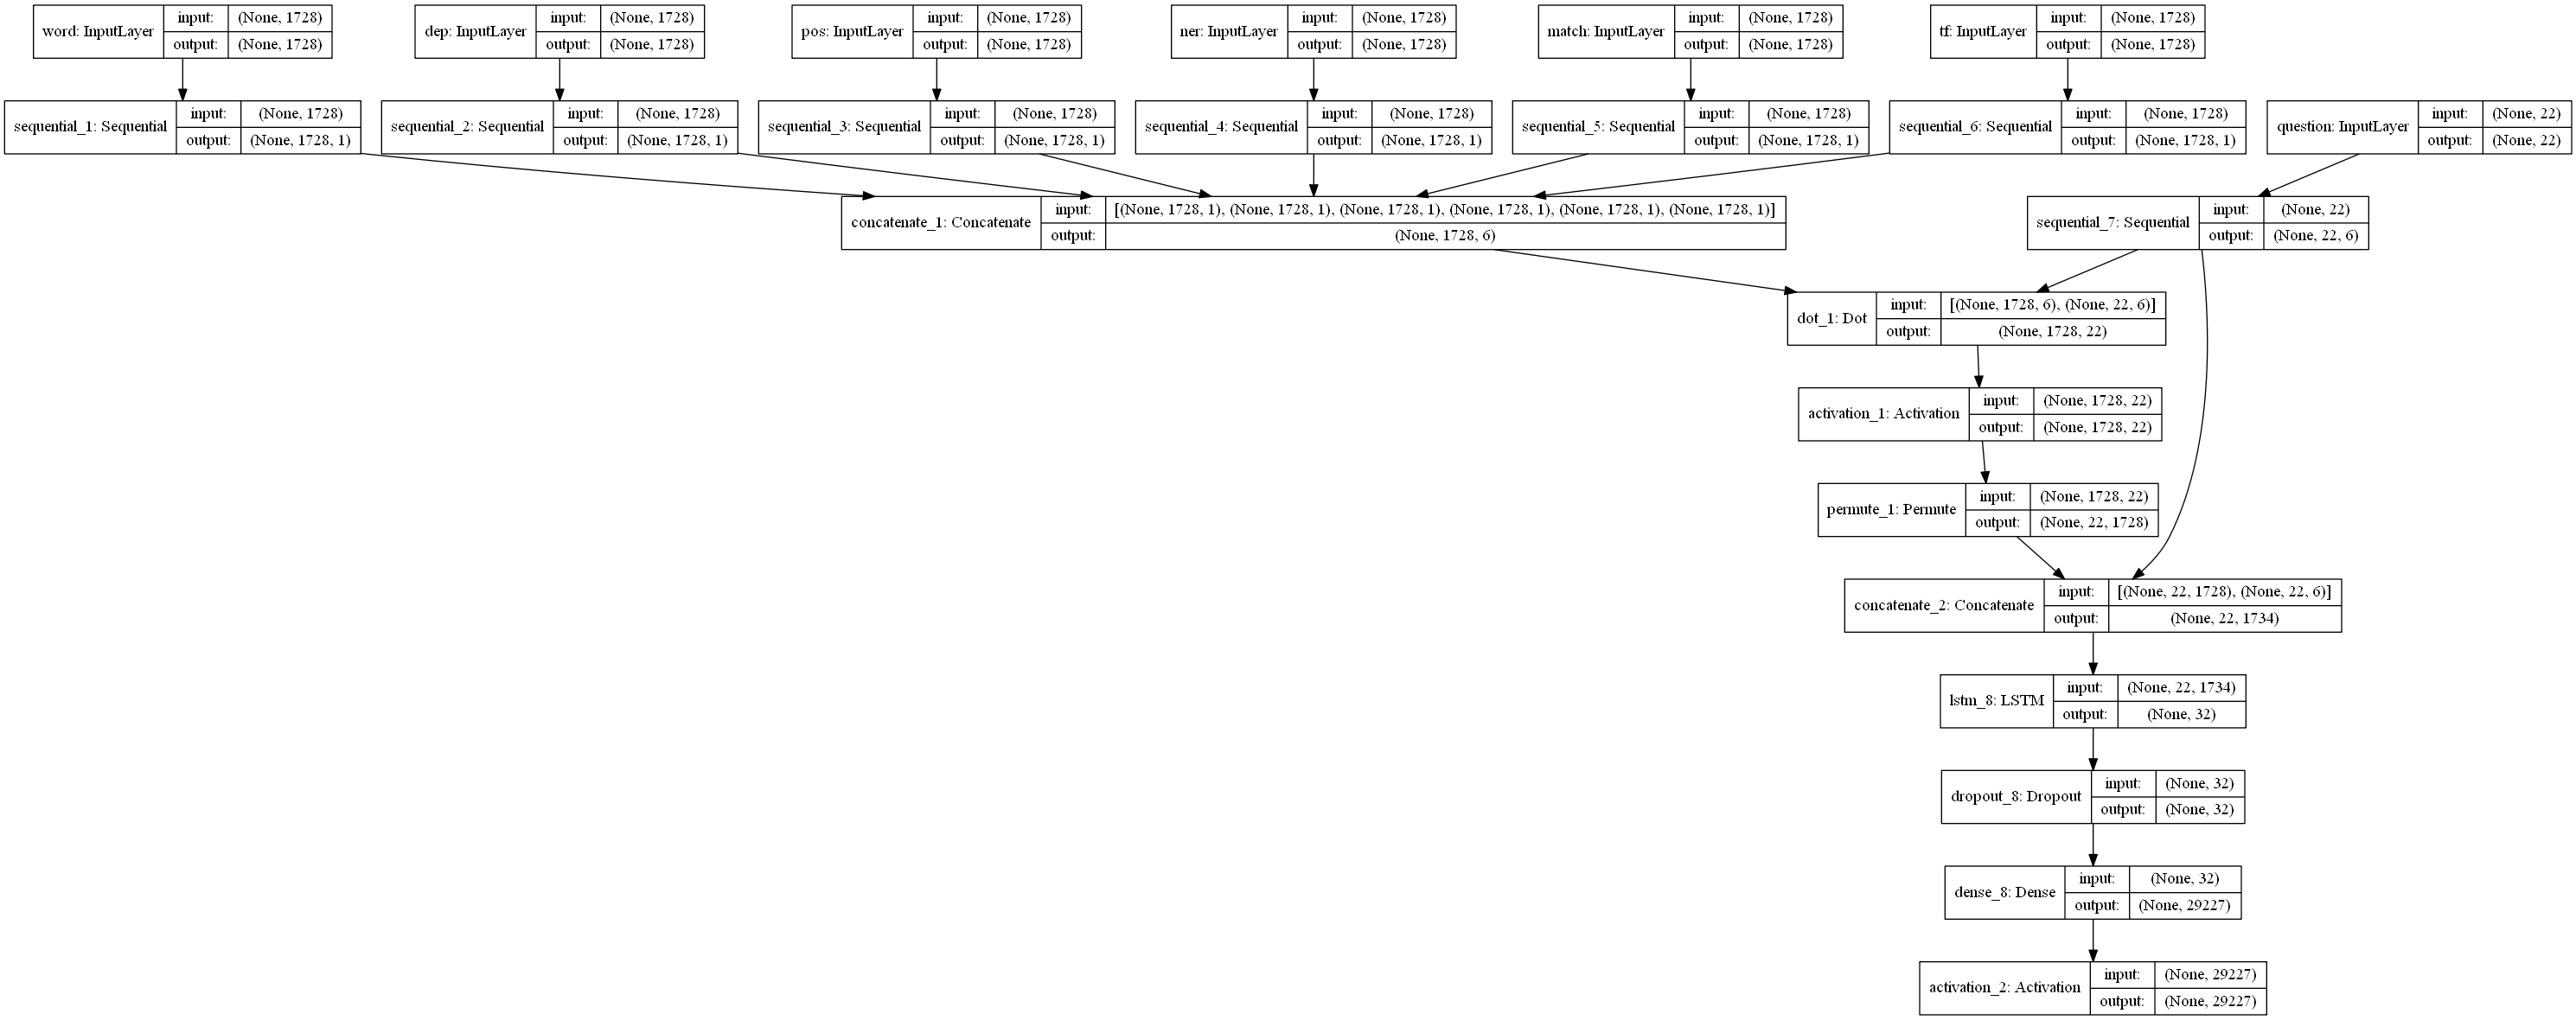

In [680]:
# plot graph
plot_model(model_first, to_file='NLP.png', show_shapes=True)
display(Image(filename='NLP.png'))

In [681]:
train_answer_first_token = np.reshape(np.array(train_answer_first_token), (-1,1))
test_answer_first_token = np.reshape(np.array(test_answer_first_token), (-1,1))

In [682]:
train_answer_last_token = np.reshape(np.array(train_answer_last_token), (-1,1))
test_answer_last_token = np.reshape(np.array(test_answer_last_token), (-1,1))

In [690]:
# train the model for first token

model_first.fit([np.array(padded_word_train),np.array(padded_dep_train),np.array(padded_pos_train),
            np.array(padded_ner_train),np.array(padded_match_train),np.array(padded_tf_train),
            np.array(padded_wordQ_train)], train_answer_first_token,
          batch_size=32,
          verbose=0,
          epochs=100,
          validation_data=([np.array(padded_word_test),np.array(padded_dep_test),np.array(padded_pos_test),
            np.array(padded_ner_test),np.array(padded_match_test),np.array(padded_tf_test),
            np.array(padded_wordQ_test)], test_answer_first_token))

In [691]:
pred1st = model_first.predict([np.array(padded_word_train),np.array(padded_dep_train),np.array(padded_pos_train),
            np.array(padded_ner_train),np.array(padded_match_train),np.array(padded_tf_train),
            np.array(padded_wordQ_train)])

pred1st_test = model_first.predict([np.array(padded_word_test),np.array(padded_dep_test),np.array(padded_pos_test),
            np.array(padded_ner_test),np.array(padded_match_test),np.array(padded_tf_test),
            np.array(padded_wordQ_test)])
preds1st = np.argmax(pred1st, axis = 1)
preds1st_test =  np.argmax(pred1st_test, axis = 1)

In [538]:
# train the model for last token

model_last.fit([np.array(padded_word_train),np.array(padded_dep_train),np.array(padded_pos_train),
            np.array(padded_ner_train),np.array(padded_match_train),np.array(padded_tf_train),
            np.array(padded_wordQ_train)], train_answer_last_token,
          batch_size=32,
          verbose=0,
          epochs=10,
          validation_data=([np.array(padded_word_test),np.array(padded_dep_test),np.array(padded_pos_test),
            np.array(padded_ner_test),np.array(padded_match_test),np.array(padded_tf_test),
            np.array(padded_wordQ_test)], test_answer_last_token))

In [541]:
predLast = model_last.predict([np.array(padded_word_train),np.array(padded_dep_train),np.array(padded_pos_train),
            np.array(padded_ner_train),np.array(padded_match_train),np.array(padded_tf_train),
            np.array(padded_wordQ_train)])

predLast_test = model_last.predict([np.array(padded_word_test),np.array(padded_dep_test),np.array(padded_pos_test),
            np.array(padded_ner_test),np.array(padded_match_test),np.array(padded_tf_test),
            np.array(padded_wordQ_test)])

predsLast = np.argmax(predLast, axis = 1)
predsLast_test =  np.argmax(predLast_test, axis = 1)

In [692]:
from sklearn.metrics import classification_report
print(' Classification report for first token on train dataset')
print(classification_report(np.array(train_answer_first_token), preds1st))

 Classification report for first token on train dataset
              precision    recall  f1-score   support

           1       0.37      0.91      0.53        69
           6       0.50      1.00      0.67         9
          10       0.76      0.97      0.85       236
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          19       0.65      0.94      0.77        51
          22       0.33      1.00      0.50         2
          23       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         7
          55       0.00      0.00      0.00         2
          61       0.00      0.00      0.00         4
          62       0.00      0.00      0.00         1
          67       0.00  

In [693]:
from sklearn.metrics import classification_report
print(' Classification report for first token on test dataset')
print(classification_report(np.array(test_answer_first_token), preds1st_test))

 Classification report for first token on test dataset


C:\Users\mimi_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       389
           1       0.03      0.10      0.05        20
           6       0.00      0.00      0.00         1
          10       0.17      0.25      0.20        71
          13       0.00      0.00      0.00         2
          19       0.04      0.21      0.07        14
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         0
          30       0.00      0.00      0.00         3
          55       0.00      0.00      0.00         1
          56       0.00      0.00      0.00         1
          78       0.04      0.20      0.06         5
          82       0.01      0.08      0.02        13
         105       0.00      0.00      0.00         3
         139       0.00      0.00      0.00         1
         160       0.00      0.00      0.00         1
         188       0.00      0.00      0.00         1
         190       0.00    

In [447]:
from sklearn.metrics import classification_report
print(' Classification report for end token on train dataset')
print(classification_report(np.array(train_answer_last_token), predsLast))

 Classification report for end token on train dataset
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          42       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          45       0.00      0.00      0.00         3
          48       0.00      0.00      0.00         1
          51       0.00      0.00      0.00         2
          60       0.00      0.00      0.00         3
          76       0.00      0.00      0.00         2
          82       0.09      0.50      0.15         2
         102       0.00      0.00      0.00         1
         103       0.24      1.00      0.39        73
         112       0.00      0.00      0.00         2
         116       0.00    

In [448]:
from sklearn.metrics import classification_report
print(' Classification report for end token on test dataset')
print(classification_report(np.array(test_answer_last_token), predsLast_test))

 Classification report for end token on test dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       389
          19       0.00      0.00      0.00         0
          51       0.00      0.00      0.00         1
          63       0.00      0.00      0.00         1
          99       0.00      0.00      0.00         2
         103       0.03      0.56      0.06        16
         104       0.00      0.00      0.00         1
         112       0.00      0.00      0.00         1
         122       0.00      0.00      0.00         0
         160       0.00      0.00      0.00         2
         204       0.00      0.00      0.00         2
         234       0.00      0.00      0.00         1
         247       0.01      0.60      0.02         5
         254       0.00      0.00      0.00         1
         259       0.00      0.00      0.00         1
         264       0.00      0.00      0.00         1
         276       0.00     

In [192]:
for k,v in doc_dict.items():
    if v == 10:
        print(v, k)
    if v == 82:
        print(v, k)
    if v == 19:
        print(v, k)
    if v == 1462:
        print(v, k)
    if v == 841:
        print(v, k)

10 the
19 in
82 it
841 he
1462 north


In [574]:
# model 2 --- excluding tf-idf feature
K.clear_session()

In [575]:
in_pos =   Input((maxlen_doc,), name = 'pos')
in_dep =   Input((maxlen_doc,), name = 'dep')
in_match = Input((maxlen_doc,), name = 'match')
in_ner =   Input((maxlen_doc,), name = 'ner')
in_word =  Input((maxlen_doc,), name = 'word')

question = Input(shape=(maxlen_q,), name = 'question')
input_encoder_m1 = Sequential()
input_encoder_m1.add(Embedding(input_dim=doc_vocab_size, output_dim=100, weights = [np.array(pretrained_list)], 
                              input_length=maxlen_doc))
input_encoder_m1.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, doc_vocab_size, 100)))
input_encoder_m1.add(Dropout(0.3))
input_encoder_m1.add(Dense(1))


input_encoder_m2 = Sequential()
input_encoder_m2.add(Embedding(input_dim=dep_vocab_size, output_dim=1, weights = [dep_vocab_list],
                               input_length=maxlen_doc))
input_encoder_m2.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, dep_vocab_size, 1)))
input_encoder_m2.add(Dropout(0.3))
input_encoder_m2.add(Dense(1))

input_encoder_m3 = Sequential()
input_encoder_m3.add(Embedding(input_dim=pos_vocab_size, output_dim=1, weights = [pos_vocab_list],
                              input_length=maxlen_doc))
input_encoder_m3.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, pos_vocab_size, 1)))
input_encoder_m3.add(Dropout(0.3))
input_encoder_m3.add(Dense(1))

input_encoder_m4 = Sequential()
input_encoder_m4.add(Embedding(input_dim=ner_vocab_size, output_dim=1, weights = [ner_vocab_list],
                              input_length=maxlen_doc))
input_encoder_m4.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, ner_vocab_size, 1)))
input_encoder_m4.add(Dropout(0.3))
input_encoder_m4.add(Dense(1))

input_encoder_m5 = Sequential()
input_encoder_m5.add(Embedding(input_dim=match_vocab_size, output_dim=1, weights = [match_vocab_list],
                              input_length=maxlen_doc))
input_encoder_m5.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, match_vocab_size, 1)))
input_encoder_m5.add(Dropout(0.3))
input_encoder_m5.add(Dense(1))

In [576]:
# QUESTION ENCODER

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=doc_vocab_size,
                               output_dim=100 , weights = [np.array(pretrained_list)], 
                               input_length=maxlen_q))
question_encoder.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, doc_vocab_size, 100)))
question_encoder.add(Dropout(0.3))
question_encoder.add(Dense(5))
# output: (samples, query_maxlen, 5)

# ATTENTION

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m1 = input_encoder_m1(in_word)
input_encoded_m2 = input_encoder_m2(in_dep)
input_encoded_m3 = input_encoder_m3(in_pos)
input_encoded_m4 = input_encoder_m4(in_ner)
input_encoded_m5 = input_encoder_m5(in_match)
input_encoded_m6 = input_encoder_m6(in_tf)
input_encoded_m = concatenate([input_encoded_m1,input_encoded_m2,input_encoded_m3,
                              input_encoded_m4,input_encoded_m5])


question_encoded = question_encoder(question)

# # compute a 'match' between the first input vector sequence
# # and the question vector sequence
# # shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)
response = Permute((2, 1))(match)  # (samples, query_maxlen, story_maxlen)
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded], axis = 2)

answer = LSTM(32)(answer)  # (samples, 32)
# one regularization layer
answer = Dropout(0.3)(answer)
answer = Dense(doc_vocab_size)(answer)  # (samples, vocab_size)

# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)
print('answer shape', answer.shape)
# build the final model

modell = Model([in_word,in_dep,in_pos,in_ner,in_match, question], answer)

modell.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1 = Model([in_word,in_dep,in_pos,in_ner,in_match, question], answer)

model1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

answer shape (?, 29227)


In [578]:
# train the model for first token

modell.fit([np.array(padded_word_train),np.array(padded_dep_train),np.array(padded_pos_train),
            np.array(padded_ner_train),np.array(padded_match_train),
            np.array(padded_wordQ_train)], train_answer_first_token,
          batch_size=32,
          verbose=0,
          epochs=10,
          validation_data=([np.array(padded_word_test),np.array(padded_dep_test),np.array(padded_pos_test),
            np.array(padded_ner_test),np.array(padded_match_test),
            np.array(padded_wordQ_test)], test_answer_first_token))

pred = modell.predict([np.array(padded_word_train),np.array(padded_dep_train),np.array(padded_pos_train),
            np.array(padded_ner_train),np.array(padded_match_train),
            np.array(padded_wordQ_train)])

pred_test = modell.predict([np.array(padded_word_test),np.array(padded_dep_test),np.array(padded_pos_test),
            np.array(padded_ner_test),np.array(padded_match_test),
            np.array(padded_wordQ_test)])

preds = np.argmax(pred, axis = 1)
preds_test =  np.argmax(pred_test, axis = 1)


In [580]:
# train the model for last token

model1.fit([np.array(padded_word_train),np.array(padded_dep_train),np.array(padded_pos_train),
            np.array(padded_ner_train),np.array(padded_match_train),
            np.array(padded_wordQ_train)], train_answer_last_token,
          batch_size=32,
          verbose=0,
          epochs=10,
          validation_data=([np.array(padded_word_test),np.array(padded_dep_test),np.array(padded_pos_test),
            np.array(padded_ner_test),np.array(padded_match_test),
            np.array(padded_wordQ_test)], test_answer_last_token))

pred1 = model1.predict([np.array(padded_word_train),np.array(padded_dep_train),np.array(padded_pos_train),
            np.array(padded_ner_train),np.array(padded_match_train),
            np.array(padded_wordQ_train)])

pred1_test = model1.predict([np.array(padded_word_test),np.array(padded_dep_test),np.array(padded_pos_test),
            np.array(padded_ner_test),np.array(padded_match_test),
            np.array(padded_wordQ_test)])

preds1 = np.argmax(pred1, axis = 1)
preds1_test =  np.argmax(pred1_test, axis = 1)

In [581]:
from sklearn.metrics import classification_report
print(' Classification report for first token on train dataset')
print(classification_report(np.array(train_answer_first_token), preds))


 Classification report for first token on train dataset
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        69
           6       0.00      0.00      0.00         9
          10       0.23      1.00      0.37       236
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          19       0.00      0.00      0.00        51
          22       0.00      0.00      0.00         2
          23       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         7
          55       0.00      0.00      0.00         2
          61       0.00      0.00      0.00         4
          62       0.00      0.00      0.00         1
          67       0.00  

In [582]:
from sklearn.metrics import classification_report
print(' Classification report for first token on test dataset')
print(classification_report(np.array(test_answer_first_token), preds_test))


 Classification report for first token on test dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       389
           1       0.00      0.00      0.00        20
           6       0.00      0.00      0.00         1
          10       0.10      1.00      0.19        71
          13       0.00      0.00      0.00         2
          19       0.00      0.00      0.00        14
          21       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         3
          55       0.00      0.00      0.00         1
          56       0.00      0.00      0.00         1
          78       0.00      0.00      0.00         5
          82       0.00      0.00      0.00        13
         105       0.00      0.00      0.00         3
         139       0.00      0.00      0.00         1
         160       0.00      0.00      0.00         1
         188       0.00      0.00      0.00         1
         190       0.00   

In [586]:
from sklearn.metrics import classification_report
print(' Classification report for end token on train dataset')
print(classification_report(np.array(train_answer_last_token), preds1))


 Classification report for end token on train dataset


C:\Users\mimi_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          42       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          45       0.00      0.00      0.00         3
          48       0.00      0.00      0.00         1
          51       0.00      0.00      0.00         2
          60       0.00      0.00      0.00         3
          76       0.00      0.00      0.00         2
          82       0.00      0.00      0.00         2
         102       0.00      0.00      0.00         1
         103       0.07      1.00      0.13        73
         112       0.00      0.00      0.00         2
         116       0.00      0.00      0.00         1
         122       0.00    

In [587]:
from sklearn.metrics import classification_report
print(' Classification report for end token on test dataset')
print(classification_report(np.array(test_answer_last_token), preds1_test))

 Classification report for end token on test dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       389
          51       0.00      0.00      0.00         1
          63       0.00      0.00      0.00         1
          99       0.00      0.00      0.00         2
         103       0.02      1.00      0.05        16
         104       0.00      0.00      0.00         1
         112       0.00      0.00      0.00         1
         160       0.00      0.00      0.00         2
         204       0.00      0.00      0.00         2
         234       0.00      0.00      0.00         1
         247       0.00      0.00      0.00         5
         254       0.00      0.00      0.00         1
         259       0.00      0.00      0.00         1
         264       0.00      0.00      0.00         1
         276       0.00      0.00      0.00         1
         278       0.00      0.00      0.00         1
         291       0.00     

In [588]:
## MODEL 3--- EXCLUDING DEPENDECY PARSING FEATURE
K.clear_session()

In [589]:
in_pos =   Input((maxlen_doc,), name = 'pos')
in_tf =   Input((maxlen_doc,), name = 'tf')
in_match = Input((maxlen_doc,), name = 'match')
in_ner =   Input((maxlen_doc,), name = 'ner')
in_word =  Input((maxlen_doc,), name = 'word')

question = Input(shape=(maxlen_q,), name = 'question')
input_encoder_m1 = Sequential()
input_encoder_m1.add(Embedding(input_dim=doc_vocab_size, output_dim=100, weights = [np.array(pretrained_list)], 
                              input_length=maxlen_doc))
input_encoder_m1.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, doc_vocab_size, 100)))
input_encoder_m1.add(Dropout(0.3))
input_encoder_m1.add(Dense(1))



input_encoder_m3 = Sequential()
input_encoder_m3.add(Embedding(input_dim=pos_vocab_size, output_dim=1, weights = [pos_vocab_list],
                              input_length=maxlen_doc))
input_encoder_m3.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, pos_vocab_size, 1)))
input_encoder_m3.add(Dropout(0.3))
input_encoder_m3.add(Dense(1))

input_encoder_m4 = Sequential()
input_encoder_m4.add(Embedding(input_dim=ner_vocab_size, output_dim=1, weights = [ner_vocab_list],
                              input_length=maxlen_doc))
input_encoder_m4.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, ner_vocab_size, 1)))
input_encoder_m4.add(Dropout(0.3))
input_encoder_m4.add(Dense(1))

input_encoder_m5 = Sequential()
input_encoder_m5.add(Embedding(input_dim=match_vocab_size, output_dim=1, weights = [match_vocab_list],
                              input_length=maxlen_doc))
input_encoder_m5.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, match_vocab_size, 1)))
input_encoder_m5.add(Dropout(0.3))
input_encoder_m5.add(Dense(1))

input_encoder_m6 = Sequential()
input_encoder_m6.add(Embedding(input_dim=tf_vocab_size, output_dim=1, weights = [tf_vocab_list],
                              input_length=maxlen_doc))
input_encoder_m6.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, tf_vocab_size, 1)))
input_encoder_m6.add(Dropout(0.3))
input_encoder_m6.add(Dense(1))

In [590]:
# QUESTION ENCODER

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=doc_vocab_size,
                               output_dim=100 , weights = [np.array(pretrained_list)], 
                               input_length=maxlen_q))
question_encoder.add(LSTM(10, return_sequences= True, 
                         batch_input_shape=(1039, doc_vocab_size, 100)))
question_encoder.add(Dropout(0.3))
question_encoder.add(Dense(5))
# output: (samples, query_maxlen, 6)
# ATTENTION

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m1 = input_encoder_m1(in_word)
input_encoded_m3 = input_encoder_m3(in_pos)
input_encoded_m4 = input_encoder_m4(in_ner)
input_encoded_m5 = input_encoder_m5(in_match)
input_encoded_m6 = input_encoder_m6(in_tf)
input_encoded_m = concatenate([input_encoded_m1,input_encoded_m3,
                              input_encoded_m4,input_encoded_m5,input_encoded_m6])


question_encoded = question_encoder(question)

# # compute a 'match' between the first input vector sequence
# # and the question vector sequence
# # shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)
response = Permute((2, 1))(match)  # (samples, query_maxlen, story_maxlen)
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded], axis = 2)

answer = LSTM(32)(answer)  # (samples, 32)
# one regularization layer
answer = Dropout(0.3)(answer)
answer = Dense(doc_vocab_size)(answer)  # (samples, vocab_size)

# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)
print('answer shape', answer.shape)

answer shape (?, 29227)


In [591]:
# build the final model

modell = Model([in_word,in_pos,in_ner,in_match,in_tf, question], answer)

modell.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1 = Model([in_word,in_pos,in_ner,in_match,in_tf, question], answer)

model1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# train the model for first token

modell.fit([np.array(padded_word_train),np.array(padded_pos_train),
            np.array(padded_ner_train),np.array(padded_match_train),np.array(padded_tf_train),
            np.array(padded_wordQ_train)], train_answer_first_token,
          batch_size=32,
          verbose=0,
          epochs=10,
          validation_data=([np.array(padded_word_test),np.array(padded_pos_test),
            np.array(padded_ner_test),np.array(padded_match_test),np.array(padded_tf_test),
            np.array(padded_wordQ_test)], test_answer_first_token))

pred = modell.predict([np.array(padded_word_train),np.array(padded_pos_train),
            np.array(padded_ner_train),np.array(padded_match_train),np.array(padded_tf_train),
            np.array(padded_wordQ_train)])

pred_test = modell.predict([np.array(padded_word_test),np.array(padded_pos_test),
            np.array(padded_ner_test),np.array(padded_match_test),np.array(padded_tf_test),
            np.array(padded_wordQ_test)])

preds = np.argmax(pred, axis = 1)
preds_test =  np.argmax(pred_test, axis = 1)


In [592]:
# train the model for last token

model1.fit([np.array(padded_word_train),np.array(padded_pos_train),
            np.array(padded_ner_train),np.array(padded_match_train),np.array(padded_tf_train),
            np.array(padded_wordQ_train)], train_answer_last_token,
          batch_size=32,
          verbose=0,
          epochs=10,
          validation_data=([np.array(padded_word_test),np.array(padded_pos_test),
            np.array(padded_ner_test),np.array(padded_match_test),np.array(padded_tf_test),
            np.array(padded_wordQ_test)], test_answer_last_token))

pred1 = model1.predict([np.array(padded_word_train),np.array(padded_pos_train),
            np.array(padded_ner_train),np.array(padded_match_train),np.array(padded_tf_train),
            np.array(padded_wordQ_train)])

pred1_test = model1.predict([np.array(padded_word_test),np.array(padded_pos_test),
            np.array(padded_ner_test),np.array(padded_match_test),np.array(padded_tf_test),
            np.array(padded_wordQ_test)])

preds1 = np.argmax(pred1, axis = 1)
preds1_test =  np.argmax(pred1_test, axis = 1)


In [593]:
from sklearn.metrics import classification_report
print(' Classification report for first token on train dataset')
print(classification_report(np.array(train_answer_first_token), preds))

 Classification report for first token on train dataset
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        69
           6       0.00      0.00      0.00         9
          10       0.23      1.00      0.37       236
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          19       0.00      0.00      0.00        51
          22       0.00      0.00      0.00         2
          23       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         7
          55       0.00      0.00      0.00         2
          61       0.00      0.00      0.00         4
          62       0.00      0.00      0.00         1
          67       0.00  

In [594]:
from sklearn.metrics import classification_report
print(' Classification report for first token on test dataset')
print(classification_report(np.array(test_answer_first_token), preds_test))

 Classification report for first token on test dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       389
           1       0.00      0.00      0.00        20
           6       0.00      0.00      0.00         1
          10       0.10      1.00      0.19        71
          13       0.00      0.00      0.00         2
          19       0.00      0.00      0.00        14
          21       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         3
          55       0.00      0.00      0.00         1
          56       0.00      0.00      0.00         1
          78       0.00      0.00      0.00         5
          82       0.00      0.00      0.00        13
         105       0.00      0.00      0.00         3
         139       0.00      0.00      0.00         1
         160       0.00      0.00      0.00         1
         188       0.00      0.00      0.00         1
         190       0.00   

In [595]:
from sklearn.metrics import classification_report
print(' Classification report for end token on train dataset')
print(classification_report(np.array(train_answer_last_token), preds1))

 Classification report for end token on train dataset
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          42       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          45       0.00      0.00      0.00         3
          48       0.00      0.00      0.00         1
          51       0.00      0.00      0.00         2
          60       0.00      0.00      0.00         3
          76       0.00      0.00      0.00         2
          82       0.00      0.00      0.00         2
         102       0.00      0.00      0.00         1
         103       0.07      1.00      0.13        73
         112       0.00      0.00      0.00         2
         116       0.00    

In [596]:
from sklearn.metrics import classification_report
print(' Classification report for end token on test dataset')
print(classification_report(np.array(test_answer_last_token), preds1_test))

 Classification report for end token on test dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       389
          51       0.00      0.00      0.00         1
          63       0.00      0.00      0.00         1
          99       0.00      0.00      0.00         2
         103       0.02      1.00      0.05        16
         104       0.00      0.00      0.00         1
         112       0.00      0.00      0.00         1
         160       0.00      0.00      0.00         2
         204       0.00      0.00      0.00         2
         234       0.00      0.00      0.00         1
         247       0.00      0.00      0.00         5
         254       0.00      0.00      0.00         1
         259       0.00      0.00      0.00         1
         264       0.00      0.00      0.00         1
         276       0.00      0.00      0.00         1
         278       0.00      0.00      0.00         1
         291       0.00     